<h1 align = 'center'> Neural Networks Demystified </h1>
<h2 align = 'center'> Part 6: Training </h2>


<h4 align = 'center' > @stephencwelch </h4>

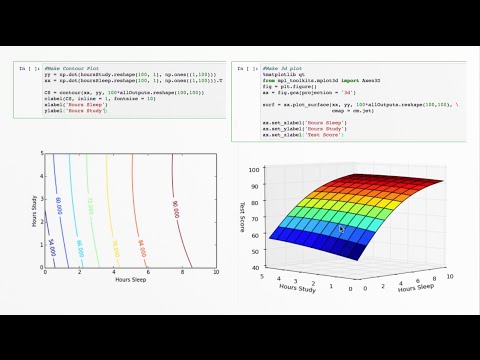

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('9KM9Td6RVgQ')

So far we’ve built a neural network in python, computed a cost function to let us know how well our network is performing, computed the gradient of our cost function so we can train our network, and last time we numerically validated our gradient computations. After all that work, it’s finally time to train our neural network. 

Back in part 3, we decided to train our network using gradient descent. While gradient descent is conceptually pretty straight forward, its implementation can actually be quite complex- especially as we increase the size and number of layers in our neural network. If we just march downhill with consistent step sizes, we may get stuck in a local minimum or flat spot, we may move too slowly and never reach our minimum, or we may move to quickly and bounce out of our minimum. And remember, all this must happen in high-dimensional space, making things significantly more complex. Gradient descent is a wonderfully clever method, but provides no guarantees that we will converge to a good solution, that we will converge to a solution in a certain amount of time, or that we will converge to a solution at all.  

The good and bad news here is that this problem is not unique to Neural Networks - there’s an entire field dedicated to finding the best combination of inputs to minimize the output of an objective function: the field of Mathematical Optimization. The bad news is that optimization can be a bit overwhelming; there are many different techniques we could apply to our problem. 

Part of what makes the optimization challenging is the broad range of approaches covered - from very rigorous, theoretical methods to hands-on, more heuristics-driven methods. Yann Lecun’s 1998 publication Efficient BackProp presents an excellent review of various optimization techniques as applied to neural networks. 

Here, we’re going to use a more sophisticated variant on gradient descent, the popular Broyden-Fletcher-Goldfarb-Shanno numerical optimization algorithm. The BFGS algorithm overcomes some of the limitations of plain gradient descent by estimating the second derivative, or curvature, of the cost function surface, and using this information to make more informed movements downhill. BFGS will allow us to find solutions more often and more quickly. 

We’ll use the BFGS implementation built into the scipy optimize package, specifically within the minimize function. To use BFGS, the minimize function requires us to pass in an objective function that accepts a vector of parameters, input data, and output data, and returns both the cost and gradients. Our neural network implementation doesn’t quite follow these semantics, so we’ll use a wrapper function to give it this behavior. We’ll also pass in initial parameters, set the jacobian parameter to true since we’re computing the gradient within our neural network class, set the method to BFGS, pass in our input and output data, and some options. Finally, we’ll implement a callback function that allows us to track the cost function value as we train the network. Once the network is trained, we’ll replace the original, random parameters, with the trained parameters. 

In [2]:
%pylab inline
#Import code from previous videos:
from partFive import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy import optimize

In [4]:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))   
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def train(self, X, y):
        #Make an internal variable for the callback function:
        self.X = X
        self.y = y

        #Make empty list to store costs:
        self.J = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(X, y), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res
    

If we plot the cost against the number of iterations through training, we should see a nice, monotonically decreasing function. Further, we see that the number of function evaluations required to find the solution is less than 100, and far less than the 10^27 function evaluation that would have been required to find a solution by brute force, as shown in part 3. Finally, we can evaluate our gradient at our solution and see very small values – which make sense, as our minimum should be quite flat. 

In [5]:
NN = Neural_Network()

In [6]:
T = trainer(NN)

In [7]:
T.train(X,y)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 79
         Function evaluations: 91
         Gradient evaluations: 91


Text(0, 0.5, 'Cost')

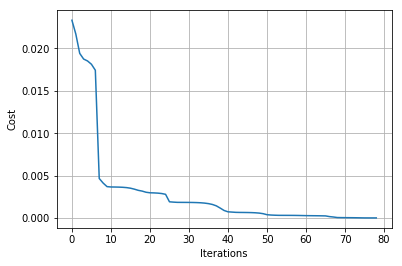

In [8]:
plot(T.J)
grid(1)
xlabel('Iterations')
ylabel('Cost')

In [9]:
NN.costFunctionPrime(X,y)

(array([[-9.78331890e-08,  2.99457525e-07, -1.17741299e-06],
        [-2.17532388e-07,  9.40939258e-07, -5.51026270e-07]]),
 array([[3.06555391e-06],
        [2.88834372e-06],
        [2.81995416e-07]]))

The more exciting thing here is that we finally have a trained network that can predict your score on a test based on how many hours you sleep and how many hours you study the night before. If we run our training data through our forward method now, we see that our predictions are excellent. We can go one step further and explore the input space for various combinations of hours sleeping and hours studying, and maybe we can find an optimal combination of the two for your next test. 

In [10]:
NN.forward(X)

array([[0.7500044 ],
       [0.82000952],
       [0.93001575]])

In [11]:
y

array([[0.75],
       [0.82],
       [0.93]])

In [12]:
#Test network for various combinations of sleep/study:
hoursSleep = linspace(0, 10, 100)
hoursStudy = linspace(0, 5, 100)

#Normalize data (same way training data way normalized)
hoursSleepNorm = hoursSleep/10.
hoursStudyNorm = hoursStudy/5.

#Create 2-d versions of input for plotting
a, b  = meshgrid(hoursSleepNorm, hoursStudyNorm)

#Join into a single input matrix:
allInputs = np.zeros((a.size, 2))
allInputs[:, 0] = a.ravel()
allInputs[:, 1] = b.ravel()

In [13]:
allOutputs = NN.forward(allInputs)

Text(0, 0.5, 'Hours Study')

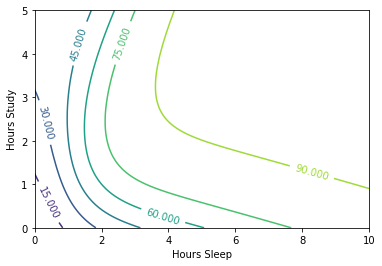

In [14]:
#Contour Plot:
yy = np.dot(hoursStudy.reshape(100,1), np.ones((1,100)))
xx = np.dot(hoursSleep.reshape(100,1), np.ones((1,100))).T

CS = contour(xx,yy,100*allOutputs.reshape(100, 100))
clabel(CS, inline=1, fontsize=10)
xlabel('Hours Sleep')
ylabel('Hours Study')

Text(0.5, 0, 'Test Score')

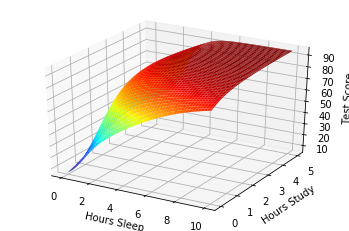

In [15]:
#3D plot:

##Uncomment to plot out-of-notebook (you'll be able to rotate)
#%matplotlib qt

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(xx, yy, 100*allOutputs.reshape(100, 100), \
                       cmap=cm.jet)

ax.set_xlabel('Hours Sleep')
ax.set_ylabel('Hours Study')
ax.set_zlabel('Test Score')

Our results look pretty reasonable, and we see that for our model, sleep actually has a bigger impact on your grade than studying – something I wish I had realized when I was in school. So we’re done, right? 
	Nope. 


We’ve made possibly the most dangerous and tempting error in machine learning – overfitting. Although our network is performing incredibly well (maybe too well) on our training data – that doesn’t mean that our model is a good fit for the real world, and that’s what we’ll work on next time. 